# Version 3

To Do

- Make file handling at the top the same as the other new-ish files. DONE
- NOw looks at the star-master for a particular filter.

# Verison 4

- Chnage to use new folder structure  - DONE
- Change to use fits to get file names etc. - DONE

In [1]:
import numpy as np

import matplotlib
matplotlib.use('TkAgg')

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit

from scipy import optimize
from astropy.time import Time

#from astropy.visualization import time_support
#from astropy.timeseries import TimeSeries

%matplotlib notebook 
import matplotlib.image as mpimg

import pandas as pd

from astropy.io import fits
from astropy.utils.data import download_file

import os
import glob
import time
from matplotlib.colors import LogNorm
from IPython import display
from IPython.display import clear_output

import random

%matplotlib inline
plt.rcParams.update({'font.size':13})

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from astropy import units as u
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats

from astropy.wcs import WCS

# conda install -c astropy astroquery

from astroquery.astrometry_net import AstrometryNet

from astroquery.simbad import Simbad

import astropy.units as u
from astropy import coordinates

import pyvo as vo

from My_Functions import Find_stars_photometery

import warnings
warnings.filterwarnings('ignore')

import astroalign as aa

from My_Functions_v3 import create_or_empty_folder
from My_Functions_v3 import update_fits_header

In [2]:
def print_columns(df):
    """ prints all the column names in a dataframe
        useful for when there's too many and df.columns
        doesn't print them all. """

    for i in range(len(df.columns)):
        print(df.columns[i])
    return()

In [3]:
main_star    = "V* RZ Cep"
file_object  = "RZ_Cep"
file_nights  = ["2022_12_07", "2023_01_23", "2023_02_23", "2023_11_10", "2024_01_07","2024_01_18"]
save_star = file_object

In [57]:
main_star    = "TYC 3023-1974-1"
file_object  = "tyc_3023-1974-1"
file_nights  = ["2023_04_02","2023_04_03"]
save_star = file_object

In [46]:
main_star    = "V* RZ Cas"
file_object  = "RZ_Cas"
file_nights  = ["2023_03_02","2023_04_06","2023_10_14","2023_11_30"]
#file_nights = ["2023_03_02","2023_04_06"]
#file_nights = ["2023_03_02","2023_04_06","2023_10_14"]
save_star = file_object

In [47]:
colour_list = "Luminance"
colour_list = "Red"
colour_list = "Green"
colour_list = "Blue"

In [48]:
#filepath_save =   "../../BPO_Data/"+file_object+"/"

master_file_path = "../../BPO_Data/"+file_object+"/"+colour_list+"/"

composite_image_file = glob.glob(master_file_path+"*weighted_mean.fits")
composite_image_file = composite_image_file[0]

composite_image_file_hdr = fits.getheader(composite_image_file)
composite_photometry_file  = composite_image_file_hdr['PHOSOLVE']
composite_photometry_file_normalisation = composite_image_file_hdr['NORMPHOT']


print(composite_image_file)
print(composite_photometry_file)

../../BPO_Data/RZ_Cas/Blue\Composite_RZ_Cas_B_weighted_mean.fits
../../BPO_Data/RZ_Cas/Blue/Composite_RZ_Cas_B_weighted_mean_photometry_solved.csv


In [49]:
file_list_individual_csv = []
file_list_individual_images = []
for file_night in file_nights:
        filepath = "../../BPO_Data/"+file_object+"/"+file_night+"/Light/"+colour_list+"/"
        files = glob.glob(filepath+"*.fits*")
        
        create_or_empty_folder(filepath+"photometry_matched/")
        
        for file in files:
            
            temp_hdr = fits.getheader(file)
            file_list_individual_csv.append(temp_hdr['PHOTFILE'])
            file_list_individual_images.append(file)

print('total number of files = '+str(len(file_list_individual_csv)))
print(print("\n".join(file_list_individual_csv)))   



Folder '../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue/photometry_matched/' has been created.
Folder '../../BPO_Data/RZ_Cas/2023_04_06/Light/Blue/photometry_matched/' has been created.
Folder '../../BPO_Data/RZ_Cas/2023_10_14/Light/Blue/photometry_matched/' has been created.
Folder '../../BPO_Data/RZ_Cas/2023_11_30/Light/Blue/photometry_matched/' has been created.
total number of files = 150
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue/photometry/RZ_Cas_Light_Blue_0.600_secs_001_photometry.csv
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue/photometry/RZ_Cas_Light_Blue_0.600_secs_002_photometry.csv
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue/photometry/RZ_Cas_Light_Blue_0.600_secs_003_photometry.csv
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue/photometry/RZ_Cas_Light_Blue_0.600_secs_004_photometry.csv
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue/photometry/RZ_Cas_Light_Blue_0.600_secs_005_photometry.csv
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue/photometry/RZ_Cas_Light_Blue_0.600_secs_006_photo

Going to use [Astroalign](https://astroalign.quatrope.org/en/latest/) to get all the star lists in the same order, or soemthing like that.

In [50]:
composite_image = fits.getdata(composite_image_file)

hdul = fits.open(composite_image_file)

<Figure size 2500x2700 with 0 Axes>

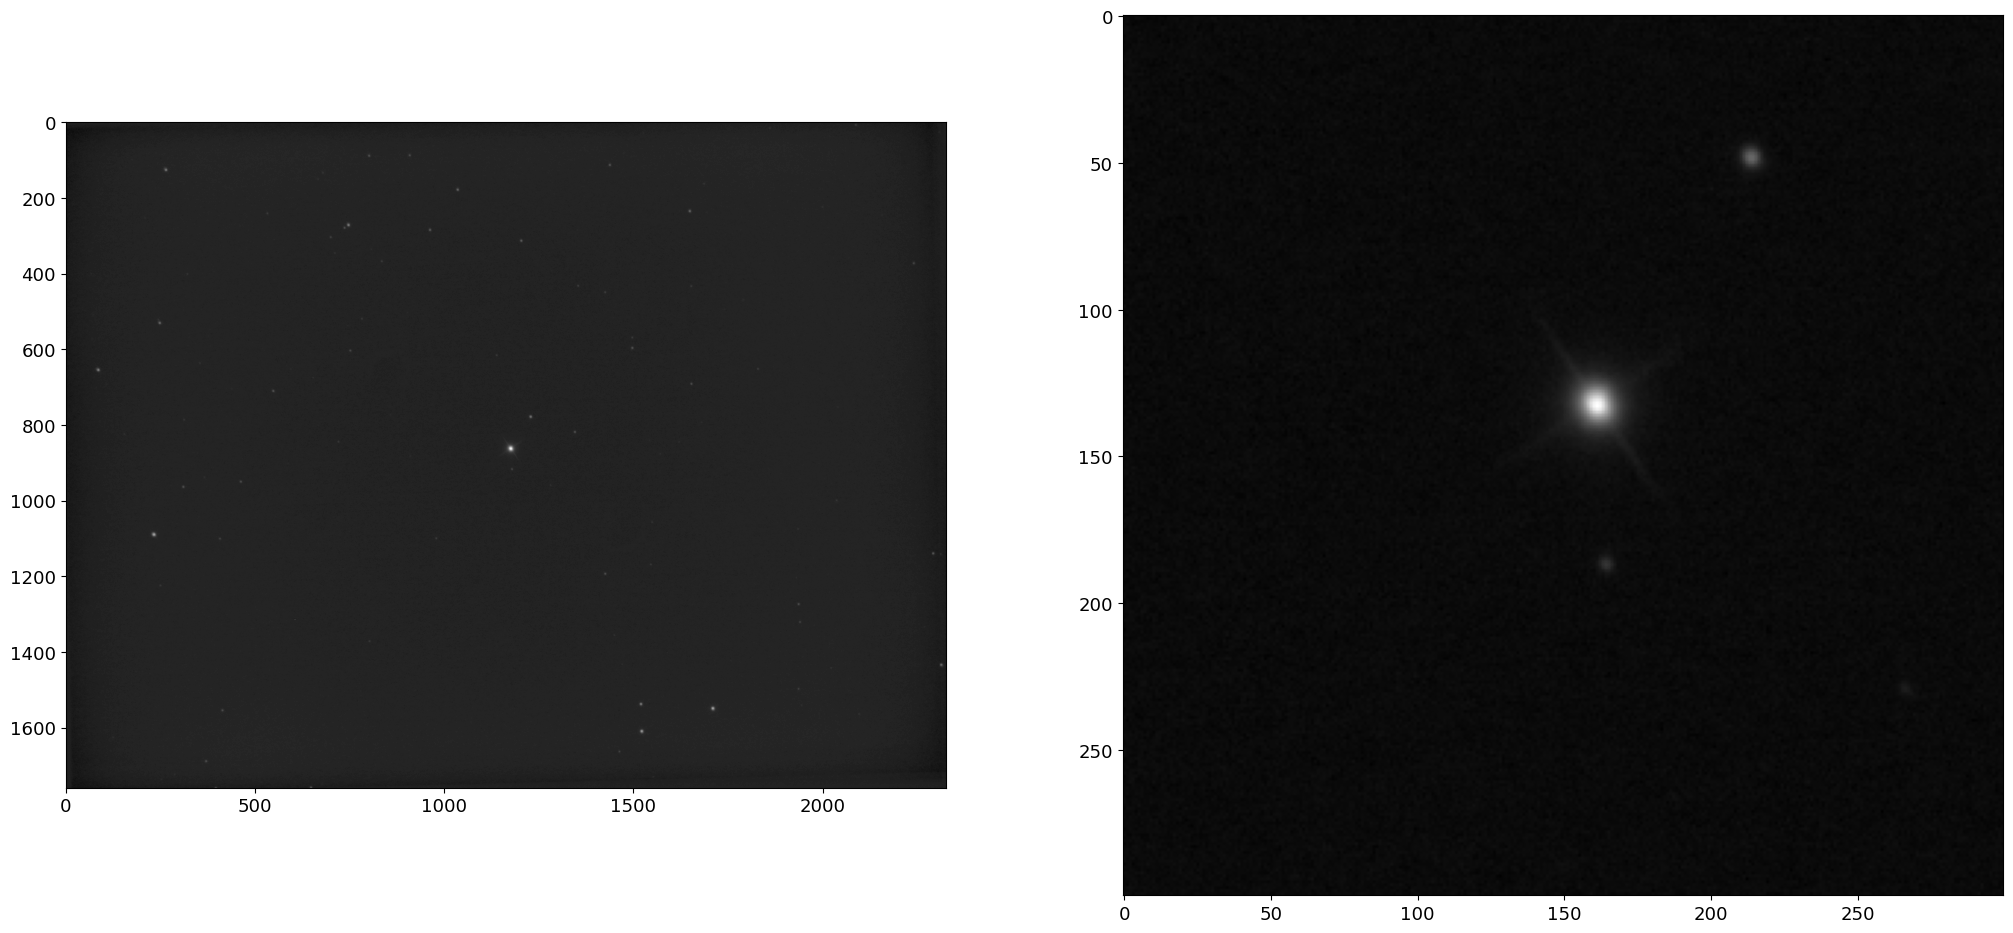

In [51]:
fig = plt.figure(figsize=(25,27))


fig = plt.figure(figsize=(25,27))
#ax1.cla()
ax1 = plt.subplot(1,2,1)
ax1.imshow(composite_image,cmap='gray',norm=LogNorm())

nopixels=150
ax2 = plt.subplot(1,2,2)
ax2.imshow(composite_image[int(composite_image.shape[0]/2-nopixels):int(composite_image.shape[0]/2+nopixels),int(composite_image.shape[1]/2-nopixels):int(composite_image.shape[1]/2+nopixels)],cmap='gray'\
           ,norm=LogNorm())
plt.show()

In [52]:
df_photometry = pd.read_csv(composite_photometry_file)

<Figure size 2500x2700 with 0 Axes>

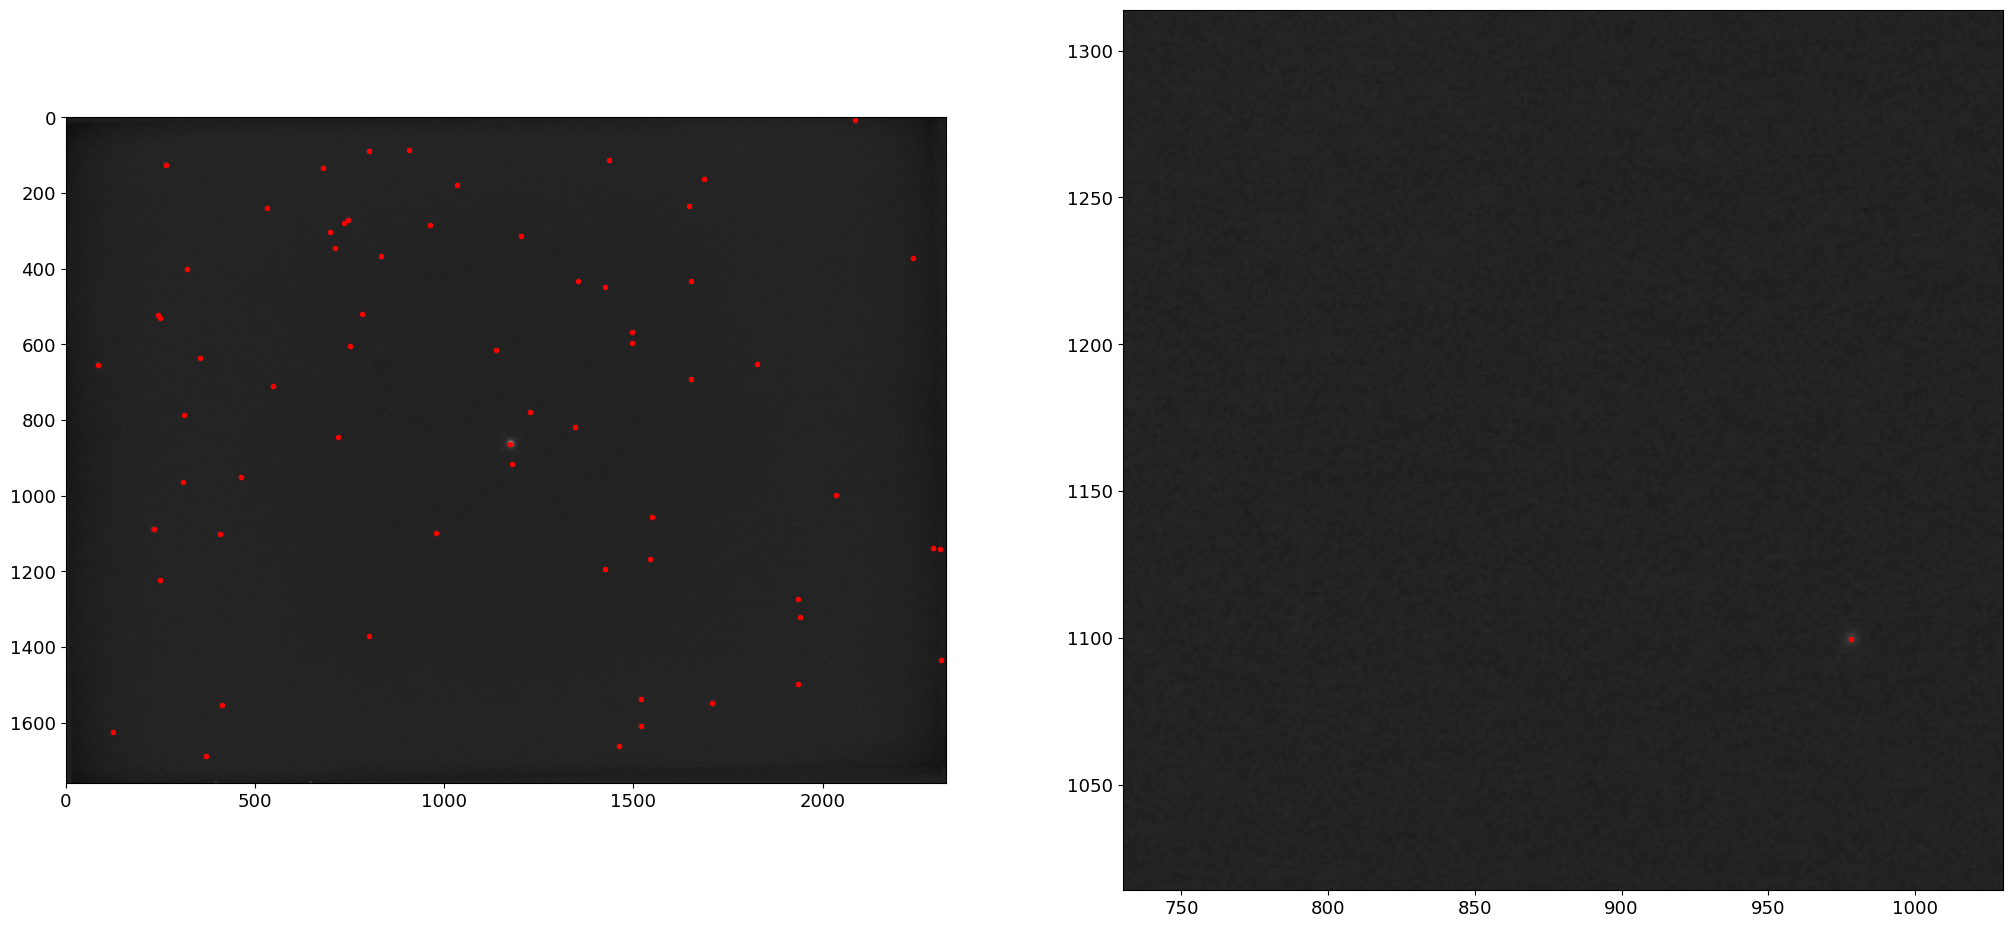

In [53]:
fig = plt.figure(figsize=(25,27))


fig = plt.figure(figsize=(25,27))
#ax1.cla()
ax1 = plt.subplot(1,2,1)
ax1.imshow(composite_image,cmap='gray',norm=LogNorm())
ax1.plot(df_photometry['xcenter'],df_photometry['ycenter'],'.r')

nopixels=150
ax2 = plt.subplot(1,2,2)
ax2.imshow(composite_image,cmap='gray'\
           ,norm=LogNorm())
ax2.set_xlim([int(composite_image.shape[0]/2-nopixels),int(composite_image.shape[0]/2+nopixels)])
ax2.set_ylim([int(composite_image.shape[1]/2-nopixels),int(composite_image.shape[1]/2+nopixels)])
ax2.plot(df_photometry['xcenter'],df_photometry['ycenter'],'.r')

plt.show()

In [54]:
df_target = pd.read_csv(composite_photometry_file, index_col=0)
target = pd.concat([df_target['xcenter'],df_target['ycenter']], axis=1)

In [55]:
transfs = []
source_lists = [] 
target_lists = []
nnumber_matching_stars = []

bad_files = []

for i in range(len(file_list_individual_csv)):
    
        clear_output(wait=True)
        print(i,len(file_list_individual_csv))
        print(file_list_individual_csv[i])
        
        df_source = pd.read_csv(file_list_individual_csv[i], index_col=0)
        source =  pd.concat([df_source['xcenter'],df_source['ycenter']], axis=1)
        # If too many stars it gets confused. Try 100 seems to work.
        try:
            transf, (source_list, target_list) = aa.find_transform(source,target,max_control_points=20)

            transfs.append(transf)
            source_lists.append(source_list)
            target_lists.append(target_list)
            nnumber_matching_stars.append(len(target_list))

            # Vcky's magic stuff. 
            df_matched_source = df_source.iloc[pd.Index(df_source['xcenter']).get_indexer(source_list[:,0])]
            df_matched_source.reset_index(inplace=True)

            # More magic pd stuff.
            df_matched_target = df_target.iloc[pd.Index(df_target['xcenter']).get_indexer(target_list[:,0])]
            df_matched_target.reset_index(inplace=True)

            df_out = df_matched_source.join(df_matched_target['id'], rsuffix='_ref')

            df_out = df_out.join(df_matched_target['MAIN_ID'], rsuffix='_ref')
            
            
            ##########
            file_name = os.path.basename(file_list_individual_csv[i])
            new_file_name = file_name.replace('.csv','_matched.csv')
            
            filepath = "../../BPO_Data/"+file_object+"/"+file_night+"/Light/"+colour_list+"/"
            
            
            csv_filename = filepath + "photometry_matched/" + new_file_name
            update_fits_header(file_list_individual_images[i], 'PHOMATCH', csv_filename, comment="The reduced image photometry matched ot the master")
            
            
            print(csv_filename)
            
            df_out.to_csv(csv_filename)
            
        except:
            print('bad file')
            bad_files.append(file_list_individual_csv[i])
        
        time.sleep(0.01)


print('Bad files')
bad_files

149 150
../../BPO_Data/RZ_Cas/2023_11_30/Light/Blue/photometry/RZ_Cas_Light_Blue_0.600_secs_050_photometry.csv
../../BPO_Data/RZ_Cas/2023_11_30/Light/Blue/photometry_matched/RZ_Cas_Light_Blue_0.600_secs_050_photometry_matched.csv
Bad files


['../../BPO_Data/RZ_Cas/2023_10_14/Light/Blue/photometry/RZ_Cas_Light_Blue_0.400_secs_058_photometry.csv']

In [56]:
csv_filename

'../../BPO_Data/RZ_Cas/2023_11_30/Light/Blue/photometry_matched/RZ_Cas_Light_Blue_0.600_secs_050_photometry_matched.csv'